### Rotation into stream progentior frame

Creating a plotting function

In [1]:
from scipy.spatial.transform import Rotation
import numpy as np
import scipy
import pathlib
import h5py

import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.stats import median_absolute_deviation as mad_
from astropy.coordinates import CartesianRepresentation, SphericalRepresentation
import gala.dynamics as gd
import gala.coordinates as gc
from mwlmc import model as mwlmc_model
Model = mwlmc_model.MWLMC()
import yaml

import matplotlib
import matplotlib.pyplot as plt
import os
os.environ["PATH"] += os.pathsep + "/Library/TeX/texbin"
plt.style.use('my_standard.mplstyle')

galcen_v_sun = (11.1, 245, 7.3)*u.km/u.s
galcen_distance = 8.249*u.kpc

Initialising MW ... 
sphcoefs::read_coef_file: reading coefficients from file . . . success!!
Initialising LMC ... 
sphcoefs::read_coef_file: reading coefficients from file . . . success!!
Initialising MW disc ... 
cylcoefs::read_simple_coef_file: reading coefficients from file . . . success!!


sphcache::read_sph_cache: trying to read cached table . . . success!!
sphcache::read_sph_cache: trying to read cached table . . . success!!
cylcache::read_cyl_cache: trying to read cached table . . . success!!


Code to add lengths, widths & median psis to hdf5 files

In [204]:
# Nstreams=1024
# for i in range(Nstreams):
#     stream = "stream_{}.hdf5".format(i)
#     with h5py.File("/mnt/ceph/users/rbrooks/oceanus/analysis/stream-runs/full-mwh-full-mwd-no-lmc/" + stream, 'a') as file:
        
#         ds = np.linalg.norm(file["positions"][-1],axis=1)
#         length = np.nanpercentile(ds, 95) - np.nanpercentile(ds, 5)
        
#         prog = gd.PhaseSpacePosition(file["positions"][-1, 0] * u.kpc, file["velocities"][-1, 0] * u.km / u.s)
#         stream = gd.PhaseSpacePosition(file["positions"][-1, 1:].T * u.kpc, file["velocities"][-1, 1:].T * u.km / u.s)
#         R1 = Rotation.from_euler("z", -prog.spherical.lon.degree, degrees=True)
#         R2 = Rotation.from_euler("y", prog.spherical.lat.degree, degrees=True)
#         R_prog0 = R2.as_matrix() @ R1.as_matrix()  

#         new_vxyz = R_prog0 @ prog.v_xyz
#         v_angle = np.arctan2(new_vxyz[2], new_vxyz[1])
#         R3 = Rotation.from_euler("x", -v_angle.to_value(u.degree), degrees=True)
#         R = (R3 * R2 * R1).as_matrix()

#         stream_rot = gd.PhaseSpacePosition(stream.data.transform(R))
#         stream_sph = stream_rot.spherical
#         lon = stream_sph.lon.wrap_at(180*u.deg).degree
#         lat = stream_sph.lat.degree
#         width = mad_(lat, ignore_nan=True)
#         med_lon, med_lat = np.nanmedian(lon), np.nanmedian(lat)
        
#         if 'length' in file:
#             del file['length']
#         if 'width' in file:
#             del file['width']
#         if 'av_lon' in file:
#             del file['av_lon']
#         if 'av_lat' in file:
#             del file['av_lat']
        
#         # Write the datasets
#         file.create_dataset('length', data=length)
#         file.create_dataset('width', data=width)
#         file.create_dataset('av_lon', data=med_lon)
#         file.create_dataset('av_lat', data=med_lat)
        

(-90.0, 90.0)

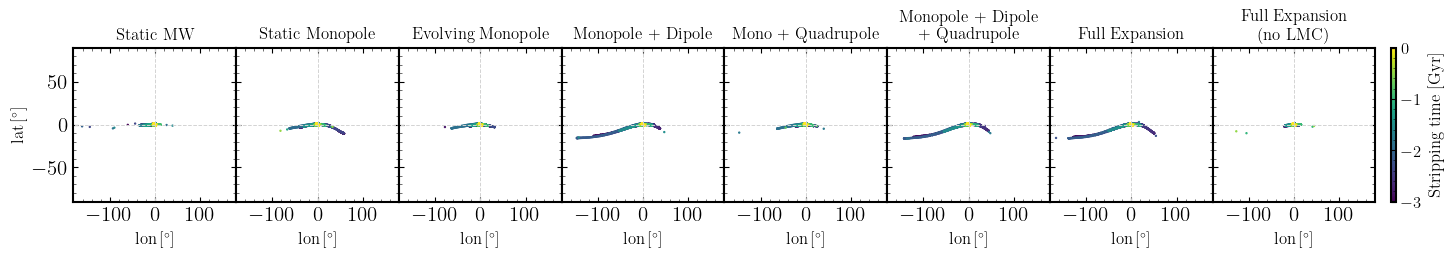

In [2]:
potentials = list(['gd1-static-mw.hdf5','gd1-rm-mwh-full-mwd-full-lmc.hdf5', 'gd1-em-mwh-full-mwd-full-lmc.hdf5', 'gd1-md-mwh-full-mwd-full-lmc.hdf5', \
                       'gd1-mq-mwh-full-mwd-full-lmc.hdf5', 'gd1-mdq-mwh-full-mwd-full-lmc.hdf5', 'gd1-full-mwh-full-mwd-full-lmc.hdf5', \
                       'gd1-full-mwh-full-mwd-no-lmc.hdf5'])
    
labels = list(['Static MW','Static Monopole', 'Evolving Monopole', 'Monopole + Dipole', 'Monopole + Quadrupole', \
               'Monopole + Dipole \n + Quadrupole', 'Full Expansion', 'Full Expansion \n (no LMC)'])

t_idx = -1

fig, ax = plt.subplots(1, len(potentials), sharex='col', sharey='row', figsize=(20,2)) 
plt.subplots_adjust(hspace=0, wspace=0.)
    
for j in range(len(potentials)): 

    #-------------------------------------------------------------------------------------
    ### Read in the data
    #-------------------------------------------------------------------------------------
    data_path = "/mnt/ceph/users/rbrooks/oceanus/analysis/stream-runs/gd1/" + potentials[j]
    with h5py.File(data_path,'r') as file:

        prog = gd.PhaseSpacePosition(file["positions"][t_idx, 0] * u.kpc, file["velocities"][t_idx, 0] * u.km / u.s)
        stream = gd.PhaseSpacePosition(file["positions"][t_idx, 1:].T * u.kpc, file["velocities"][t_idx, 1:].T * u.km / u.s)
        start_times = np.array(file['times'])
        prog_mass = np.array(file['progenitor-mass']) * u.Msun
    #-------------------------------------------------------------------------------------
    ### Rotation matrix for progenitor to get it to near (X, 0, 0)
    #-------------------------------------------------------------------------------------
    R1 = Rotation.from_euler("z", -prog.spherical.lon.degree, degrees=True)
    R2 = Rotation.from_euler("y", prog.spherical.lat.degree, degrees=True)
    R_prog0 = R2.as_matrix() @ R1.as_matrix()  
    #-------------------------------------------------------------------------------------
    ### Rotate around new x axis so stream prog vel points along +y direction
    #-------------------------------------------------------------------------------------
    new_vxyz = R_prog0 @ prog.v_xyz
    v_angle = np.arctan2(new_vxyz[2], new_vxyz[1])
    R3 = Rotation.from_euler("x", -v_angle.to_value(u.degree), degrees=True)
    R = (R3 * R2 * R1).as_matrix()
    #-------------------------------------------------------------------------------------
    ### Rotate the whole stream by the final rotation matrix
    #-------------------------------------------------------------------------------------
    prog_rot = gd.PhaseSpacePosition(prog.data.transform(R))
    prog_sph = prog_rot.spherical
    stream_rot = gd.PhaseSpacePosition(stream.data.transform(R))
    stream_sph = stream_rot.spherical
    #-------------------------------------------------------------------------------------
    ### Plot the streams
    #-------------------------------------------------------------------------------------
    plt.sca(ax[j])
    plt.hlines(0, -200, 200, ls='dashed', color='lightgrey', lw=0.7)
    plt.vlines(0, -200, 200, ls='dashed', color='lightgrey', lw=0.7)
    plot=plt.scatter(stream_sph.lon.wrap_at(180*u.deg).degree, stream_sph.lat.degree, s=.5, c=start_times[1:], cmap = 'viridis',rasterized=True)
                     # marker="o",ls="none",alpha=0.5,mew=0,ms=1.5,rasterized=True)
    # plt.scatter(prog_sph.lon.wrap_at(180*u.deg).degree, prog_sph.lat.degree, 
    #             s=150, edgecolors='k', facecolor='orange',marker='*', label='Prog.', rasterized=True)

    # if j==0:
    #     plt.annotate(text='{}'.format('stream550'), xy=(-170,70), fontsize=8 )
    #     plt.annotate(text='M = {}'.format(np.round(prog_mass.value, 0)), xy=(20,-80), fontsize=8)

cb = fig.colorbar(plot,  ax=ax, location='right', aspect=30, pad=0.01)
cb.set_label('Stripping time [Gyr]')
cb.ax.tick_params(labelsize=12)

#-------------------------------------------------------------------------------------
### Plot cosmetics
#-------------------------------------------------------------------------------------

for k in range(len(labels)):

    ax[k].set_title(labels[k])
    ax[k].set_xlabel(r'$\mathrm{lon}\,[^{\circ}]$')
    ax[k].set_xlim(-180,180)

ax[0].set_ylabel(r'$\mathrm{lat}\,[^{\circ}]$')
ax[0].set_ylim(-90,90)

# plt.savefig('/mnt/ceph/users/rbrooks/oceanus/analysis/figures/test-gd1')

(-99.0, 99.0)

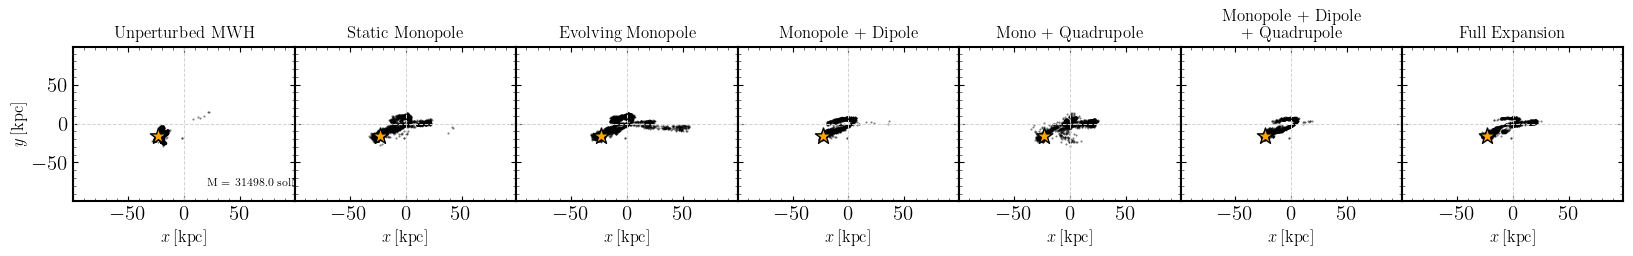

In [3]:
fig, ax = plt.subplots(1, len(potentials), sharex='col', sharey='row', figsize=(20,2)) 
plt.subplots_adjust(hspace=0, wspace=0.)
    
for j in range(len(potentials)): 

    data_path = "/mnt/ceph/users/rbrooks/oceanus/analysis/stream-runs/stream550/" + potentials[j]
    with h5py.File(data_path,'r') as file:

        prog = gd.PhaseSpacePosition(file["positions"][t_idx, 0] * u.kpc, file["velocities"][t_idx, 0] * u.km / u.s)
        stream = gd.PhaseSpacePosition(file["positions"][t_idx, 1:].T * u.kpc, file["velocities"][t_idx, 1:].T * u.km / u.s)
        start_times = np.array(file['times'])
        prog_mass = np.array(file['progenitor-mass']) * u.Msun


    plt.sca(ax[j])
    plt.hlines(0, -200, 200, ls='dashed', color='lightgrey', lw=0.7)
    plt.vlines(0, -200, 200, ls='dashed', color='lightgrey', lw=0.7)
    plot=plt.plot(stream.x, stream.y, color='k',
                     marker="o",ls="none",alpha=0.5,mew=0,ms=1.5,rasterized=True, zorder=1)
    plt.scatter(prog.x, prog.y, s=150, edgecolors='k', facecolor='orange',marker='*', label='Prog.', rasterized=True, zorder=10)

    if j==0:
        plt.annotate(text='{}'.format('stream550'), xy=(-170,70), fontsize=8 )
        plt.annotate(text=r'M = {}'.format(np.round(prog_mass, 0)), xy=(20,-80), fontsize=8)

for k in range(len(labels)):

    ax[k].set_title(labels[k])
    ax[k].set_xlabel(r'$x\,[\mathrm{kpc}]$')
    ax[k].set_xlim(-99,99)

ax[0].set_ylabel(r'$y\,[\mathrm{kpc}]$')
ax[0].set_ylim(-99,99)

(-99.0, 99.0)

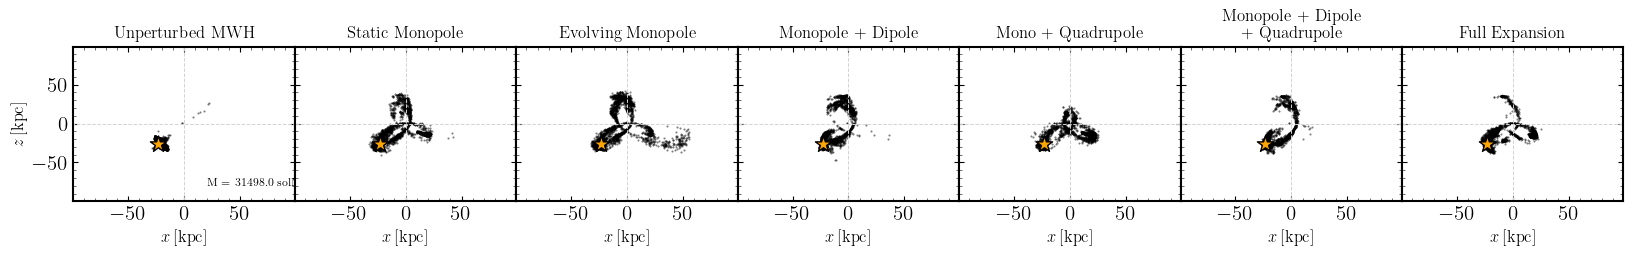

In [4]:
fig, ax = plt.subplots(1, len(potentials), sharex='col', sharey='row', figsize=(20,2)) 
plt.subplots_adjust(hspace=0, wspace=0.)
    
for j in range(len(potentials)): 

    data_path = "/mnt/ceph/users/rbrooks/oceanus/analysis/stream-runs/stream550/" + potentials[j]
    with h5py.File(data_path,'r') as file:

        prog = gd.PhaseSpacePosition(file["positions"][t_idx, 0] * u.kpc, file["velocities"][t_idx, 0] * u.km / u.s)
        stream = gd.PhaseSpacePosition(file["positions"][t_idx, 1:].T * u.kpc, file["velocities"][t_idx, 1:].T * u.km / u.s)
        start_times = np.array(file['times'])
        prog_mass = np.array(file['progenitor-mass']) * u.Msun


    plt.sca(ax[j])
    plt.hlines(0, -200, 200, ls='dashed', color='lightgrey', lw=0.7)
    plt.vlines(0, -200, 200, ls='dashed', color='lightgrey', lw=0.7)
    plot=plt.plot(stream.x, stream.z, color='k',
                     marker="o",ls="none",alpha=0.5,mew=0,ms=1.5,rasterized=True, zorder=1)
    plt.scatter(prog.x, prog.z, s=150, edgecolors='k', facecolor='orange',marker='*', label='Prog.', rasterized=True, zorder=10)

    if j==0:
        plt.annotate(text='{}'.format('stream550'), xy=(-170,70), fontsize=8 )
        plt.annotate(text=r'M = {}'.format(np.round(prog_mass, 0)), xy=(20,-80), fontsize=8)

for k in range(len(labels)):

    ax[k].set_title(labels[k])
    ax[k].set_xlabel(r'$x\,[\mathrm{kpc}]$')
    ax[k].set_xlim(-99,99)

ax[0].set_ylabel(r'$z\,[\mathrm{kpc}]$')
ax[0].set_ylim(-99,99)

(-99.0, 99.0)

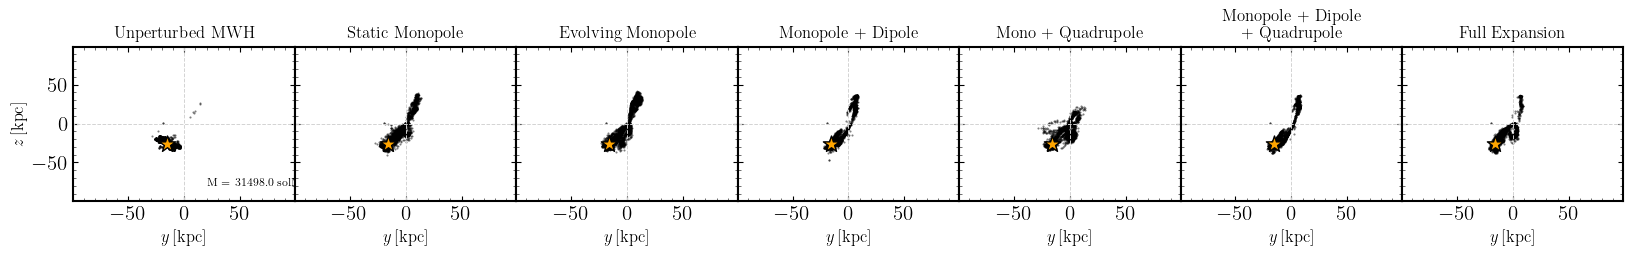

In [5]:
fig, ax = plt.subplots(1, len(potentials), sharex='col', sharey='row', figsize=(20,2)) 
plt.subplots_adjust(hspace=0, wspace=0.)
    
for j in range(len(potentials)): 

    data_path = "/mnt/ceph/users/rbrooks/oceanus/analysis/stream-runs/stream550/" + potentials[j]
    with h5py.File(data_path,'r') as file:

        prog = gd.PhaseSpacePosition(file["positions"][t_idx, 0] * u.kpc, file["velocities"][t_idx, 0] * u.km / u.s)
        stream = gd.PhaseSpacePosition(file["positions"][t_idx, 1:].T * u.kpc, file["velocities"][t_idx, 1:].T * u.km / u.s)
        start_times = np.array(file['times'])
        prog_mass = np.array(file['progenitor-mass']) * u.Msun


    plt.sca(ax[j])
    plt.hlines(0, -200, 200, ls='dashed', color='lightgrey', lw=0.7)
    plt.vlines(0, -200, 200, ls='dashed', color='lightgrey', lw=0.7)
    plot=plt.plot(stream.y, stream.z, color='k',
                     marker="o",ls="none",alpha=0.5,mew=0,ms=1.5,rasterized=True, zorder=1)
    plt.scatter(prog.y, prog.z, s=150, edgecolors='k', facecolor='orange',marker='*', label='Prog.', rasterized=True, zorder=10)

    if j==0:
        plt.annotate(text='{}'.format('stream550'), xy=(-170,70), fontsize=8 )
        plt.annotate(text=r'M = {}'.format(np.round(prog_mass, 0)), xy=(20,-80), fontsize=8)

for k in range(len(labels)):

    ax[k].set_title(labels[k])
    ax[k].set_xlabel(r'$y\,[\mathrm{kpc}]$')
    ax[k].set_xlim(-99,99)

ax[0].set_ylabel(r'$z\,[\mathrm{kpc}]$')
ax[0].set_ylim(-99,99)

In [ ]:
# def plot_stream_frames(streams, path, plotname, savefig=False):
    
#     potentials = list(['rm-MWhalo-full-MWdisc-full-LMC.hdf5', 'em-MWhalo-full-MWdisc-full-LMC.hdf5', 'md-MWhalo-full-MWdisc-full-LMC.hdf5', \
#                        'mq-MWhalo-full-MWdisc-full-LMC.hdf5', 'mdq-MWhalo-full-MWdisc-full-LMC.hdf5', 'Full-MWhalo-MWdisc-LMC.hdf5', \
#                        'full-MWhalo-full-MWdisc-no-LMC.hdf5'])
#     labels = list(['Static Monopole', 'Evolving Monopole', 'Monopole + Dipole', 'Mono + Quadrupole', \
#                       'Monopole + Dipole \n + Quadrupole', 'Full Expansion', 'Full Expansion \n (no LMC)'])
    
#     t_idx = -1
    
#     fig, ax = plt.subplots(len(streams), len(potentials), sharex='col', sharey='row', figsize=(17,5))
#     plt.subplots_adjust(hspace=0, wspace=0.)
    
#     for i in range(len(streams)): 
#         for j in range(len(potentials)):   
    
#             #-------------------------------------------------------------------------------------
#             ### Read in the data
#             #-------------------------------------------------------------------------------------
#             data_path = pathlib.Path(path) / potentials[j]
#             with h5py.File(data_path,'r') as file:
        
#                 pos = np.array(file[streams[i]]['positions'])
#                 vel = np.array(file[streams[i]]['velocities'])
#                 start_times = np.array(file[streams[i]]['times'])
#                 prog_mass = np.array(file[streams[i]]['progenitor-mass'])
                  
#             #-------------------------------------------------------------------------------------
#             ### Find the progentior Galactic coordiantes
#             #-------------------------------------------------------------------------------------
#             t0_pos, t0_vel = pos[-1], vel[-1]
#             t0_prog_pos, t0_prog_vel = t0_pos[0], t0_vel[0]
#             prog_xyz = CartesianRepresentation(t0_prog_pos[0]*u.kpc, y=t0_prog_pos[1]*u.kpc, z=t0_prog_pos[2]*u.kpc)
#             prog_Vxyz = CartesianRepresentation(t0_prog_vel[0], y=t0_prog_vel[1], z=t0_prog_vel[2])
#             GC_sph = prog_xyz.represent_as(SphericalRepresentation)
#             prog_lon, prog_lat = GC_sph.lon.deg, GC_sph.lat.deg        
     
#             #-------------------------------------------------------------------------------------
#             ### Rotation matrix for progenitor to get it to near (X, 0, 0)
#             #-------------------------------------------------------------------------------------
#             R1 = Rotation.from_euler('z', -prog_lon, degrees=True)
#             R2 = Rotation.from_euler('y', prog_lat, degrees=True)
#             R_prog0 = R2.as_matrix() @ R1.as_matrix() 
            
#             #-------------------------------------------------------------------------------------
#             ### Rotate the progenitor xyx and V_xyz
#             #-------------------------------------------------------------------------------------
#             rot_prog_pos = R_prog0 @ t0_prog_pos
#             rot_prog_vel = R_prog0 @ t0_prog_vel
            
#             #-------------------------------------------------------------------------------------
#             ### Rotate around new x axis so stream prog vel points along +y direction
#             #-------------------------------------------------------------------------------------
#             vel_rot = (np.arctan2(rot_prog_vel[2], rot_prog_vel[1])*u.rad).to(u.deg)
#             R3 = Rotation.from_euler('x', vel_rot.value, degrees=True).as_matrix() 
#             R_progf = R3 @ R_prog0
#             # R_progf = (R3 * R2 * R1).as_matrix()
            
#             #-------------------------------------------------------------------------------------
#             ### Rotate the whole stream by the final rotation matrix
#             #-------------------------------------------------------------------------------------
            
#             rot_stream_xs = np.dot(R_progf, t0_pos.T).T
#             rot_stream_vs = np.dot(R_progf, t0_vel.T).T
#             #-------------------------------------------------------------------------------------
#             ### Plot the streams
#             #-------------------------------------------------------------------------------------
                
#             plt.sca(ax[i,j])
#             print('* Plotting {} in potential {}'.format(streams[i], potentials[j]))
#             plt.hlines(0, -200, 200, ls='dashed', color='lightgrey', lw=0.7)
#             plt.vlines(0, -200, 200, ls='dashed', color='lightgrey', lw=0.7)
#             plot=plt.scatter(rot_stream_xs[:,1],rot_stream_xs[:,2], s=1, c=start_times, cmap = 'viridis',rasterized=True)
#             plt.scatter(rot_stream_xs[0][1],rot_stream_xs[0][2], s=200, edgecolors='k', facecolor='orange',marker='*', label='Prog.', rasterized=True)
            
#             if j==0:
#                 name, ext = os.path.splitext(streams[i])
#                 plt.annotate(text='{}'.format(name), xy=(-35,15), fontsize=8)
            
#     cb = fig.colorbar(plot,  ax=ax, location='right', aspect=30, pad=0.01)
#     cb.set_label('Stripping time [Gyr]')
#     cb.ax.tick_params(labelsize=12)
    
#     #-------------------------------------------------------------------------------------
#     ### Plot cosmetics
#     #-------------------------------------------------------------------------------------
    
#     lgd = ax[2,0].legend(frameon=False, fontsize=8, loc='lower left')
#     lgd.legend_handles[0]._sizes = [75]
            
#     for k in range(len(labels)):

#         ax[0,k].set_title(labels[k])
#         ax[len(streams)-1,k].set_xlabel(r'$y^{\prime}\,[\mathrm{kpc}]$')
#         ax[len(streams)-1,k].set_xlim(-39,39)
        
#     for l in range(len(streams)):
#         ax[l, 0].set_ylabel(r'$z^{\prime}\,[\mathrm{kpc}]$')
#         ax[l, 0].set_ylim(-19,19)

#     if savefig==False:
#         return
#     elif savefig==True:
#         return plt.savefig('/mnt/ceph/users/rbrooks/oceanus/analysis/figures/{}'.format(plotname))

In [2]:
def plot_stream_frames(streams, path, plotname, savefig=False):
    
    potentials = list(['static-mwh-only.hdf5','rm-MWhalo-full-MWdisc-full-LMC.hdf5', 'em-MWhalo-full-MWdisc-full-LMC.hdf5',\
                       'md-MWhalo-full-MWdisc-full-LMC.hdf5', 'mq-MWhalo-full-MWdisc-full-LMC.hdf5', 'mdq-MWhalo-full-MWdisc-full-LMC.hdf5',\
                       'Full-MWhalo-MWdisc-LMC.hdf5', 'full-MWhalo-full-MWdisc-no-LMC.hdf5'])
    
    labels = list(['Static MW','Static Monopole', 'Evolving Monopole', 'Monopole + Dipole', 'Mono + Quadrupole', \
                   'Monopole + Dipole \n + Quadrupole', 'Full Expansion', 'Full Expansion \n (no LMC)'])
              
    t_idx = -1
    
    fig, ax = plt.subplots(len(streams), len(potentials), sharex='col', sharey='row', figsize=(21,6))
    plt.subplots_adjust(hspace=0, wspace=0.)
    
    for j in range(len(potentials)): 
        for i in range(len(streams)):   
            #-------------------------------------------------------------------------------------
            ### Read in the data
            #-------------------------------------------------------------------------------------
            data_path = pathlib.Path(path) / potentials[j]
            with h5py.File(data_path,'r') as file:
        
                prog = gd.PhaseSpacePosition(file[streams[i]]["positions"][t_idx, 0] * u.kpc, file[streams[i]]["velocities"][t_idx, 0] * u.km / u.s)
                stream = gd.PhaseSpacePosition(file[streams[i]]["positions"][t_idx, 1:].T * u.kpc, file[streams[i]]["velocities"][t_idx, 1:].T * u.km / u.s)
                start_times = np.array(file[streams[i]]['times'])
                prog_mass = np.array(file[streams[i]]['progenitor-mass']) * u.Msun
                rlmc = np.array(file[streams[i]]['lmc_sep'])
            #-------------------------------------------------------------------------------------
            ### Rotation matrix for progenitor to get it to near (X, 0, 0)
            #-------------------------------------------------------------------------------------
            R1 = Rotation.from_euler("z", -prog.spherical.lon.degree, degrees=True)
            R2 = Rotation.from_euler("y", prog.spherical.lat.degree, degrees=True)
            R_prog0 = R2.as_matrix() @ R1.as_matrix()  
            #-------------------------------------------------------------------------------------
            ### Rotate around new x axis so stream prog vel points along +y direction
            #-------------------------------------------------------------------------------------
            new_vxyz = R_prog0 @ prog.v_xyz
            v_angle = np.arctan2(new_vxyz[2], new_vxyz[1])
            R3 = Rotation.from_euler("x", -v_angle.to_value(u.degree), degrees=True)
            R = (R3 * R2 * R1).as_matrix()
            #-------------------------------------------------------------------------------------
            ### Rotate the whole stream by the final rotation matrix
            #-------------------------------------------------------------------------------------
            prog_rot = gd.PhaseSpacePosition(prog.data.transform(R))
            prog_sph = prog_rot.spherical
            stream_rot = gd.PhaseSpacePosition(stream.data.transform(R))
            stream_sph = stream_rot.spherical
            lon = stream_sph.lon.wrap_at(180*u.deg).degree[:-2]
            lat = stream_sph.lat.degree[:-2]
            #-------------------------------------------------------------------------------------
            ### Plot the streams
            #-------------------------------------------------------------------------------------
            plt.sca(ax[i,j])
            # print('* Plotting {} in potential {}'.format(streams[i], potentials[j]))
            plt.hlines(0, -200, 200, ls='dashed', color='lightgrey', lw=0.7, zorder=1)
            plt.vlines(0, -200, 200, ls='dashed', color='lightgrey', lw=0.7, zorder=1)
            plot=plt.scatter(lon, lat, s=.5, c=start_times, cmap = 'viridis',rasterized=True, zorder=2)
            
            if j==0:
                name, ext = os.path.splitext(streams[i])
                plt.annotate(text='{}'.format(name), xy=(-180,65), fontsize=8 )
                plt.annotate(text=r'M = {} $\times \, 10^{{4}} \, \mathrm{{M}}_{{\odot}}$'.format(np.round(prog_mass.value/1e4, 1)),
                             xy=(-180, -80), fontsize=8)
            
    cb = fig.colorbar(plot,  ax=ax, location='right', aspect=30, pad=0.01)
    cb.set_label('Stripping time [Gyr]')
    cb.ax.tick_params(labelsize=12)
    
    #-------------------------------------------------------------------------------------
    ### Plot cosmetics
    #-------------------------------------------------------------------------------------
    for k in range(len(labels)):

        ax[0,k].set_title(labels[k])
        ax[len(streams)-1,k].set_xlabel(r'$\mathrm{lon}\,[^{\circ}]$')
        ax[len(streams)-1,k].set_xlim(-199,199)
        
    for l in range(len(streams)):
        ax[l, 0].set_ylabel(r'$\mathrm{lat}\,[^{\circ}]$')
        ax[l, 0].set_ylim(-99,99)

    if savefig==False:
        return
    elif savefig==True:
        return plt.savefig('/mnt/ceph/users/rbrooks/oceanus/analysis/figures/{}'.format(plotname))

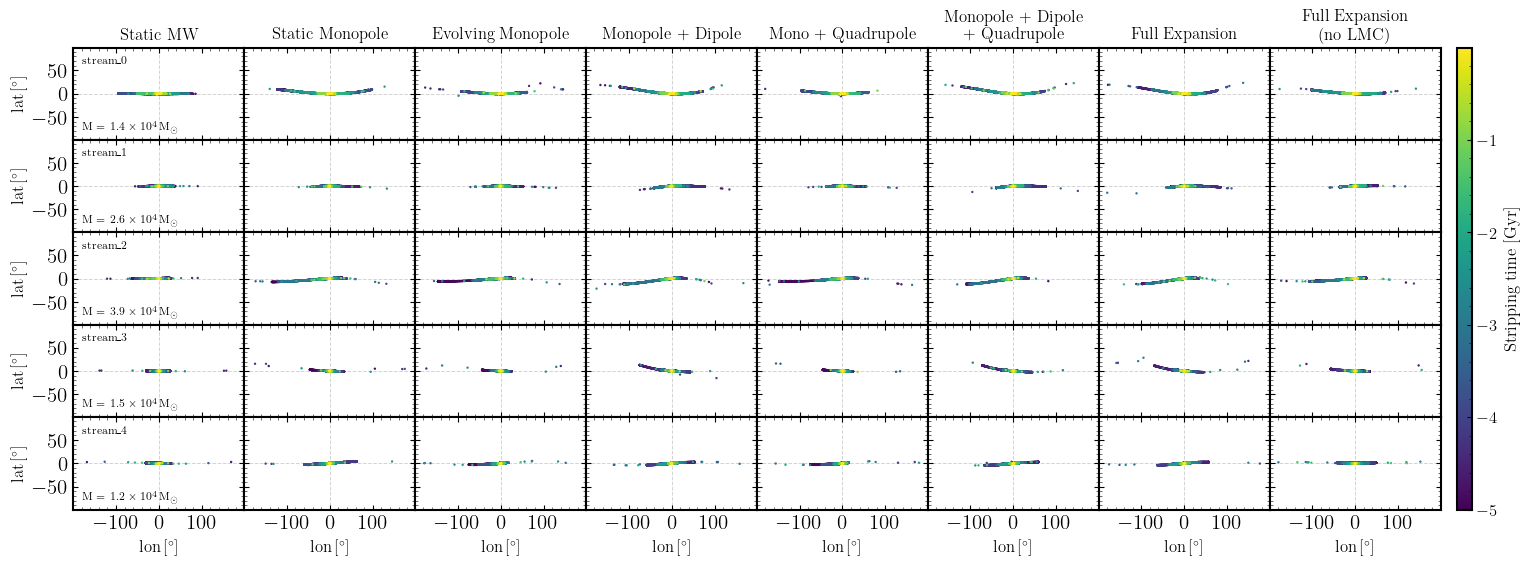

In [5]:
streams = list(['stream_0', 'stream_1','stream_2','stream_3','stream_4']) 
# streams = list(['stream_10', 'stream_22','stream_33', 'stream_36', 'stream_39',]) 
path = '/mnt/ceph/users/rbrooks/oceanus/analysis/stream-runs/combined-files/'
plotname = 'plot_stream_coords'
plot_stream_frames(streams, path, plotname, False)

In [6]:
def plot_stream_cartesian(streams, path, plotname, savefig=False):
    
    potentials = list(['static-mwh-only.hdf5','rm-MWhalo-full-MWdisc-full-LMC.hdf5', 'em-MWhalo-full-MWdisc-full-LMC.hdf5', 'md-MWhalo-full-MWdisc-full-LMC.hdf5', \
                       'mq-MWhalo-full-MWdisc-full-LMC.hdf5', 'mdq-MWhalo-full-MWdisc-full-LMC.hdf5', 'Full-MWhalo-MWdisc-LMC.hdf5', \
                       'full-MWhalo-full-MWdisc-no-LMC.hdf5'])
    labels = list(['Static MW','Static Monopole', 'Evolving Monopole', 'Monopole + Dipole', 'Mono + Quadrupole', \
                      'Monopole + Dipole \n + Quadrupole', 'Full Expansion', 'Full Expansion \n (no LMC)'])
    
    fig_yz, ax = plt.subplots(len(streams), len(potentials), sharex='col', sharey='row', figsize=(19,5))
    plt.subplots_adjust(hspace=0, wspace=0.)
    
    for i in range(len(streams)): 
        for j in range(len(potentials)):   
    
            #-------------------------------------------------------------------------------------
            ### Read in the data
            #-------------------------------------------------------------------------------------
            data_path = pathlib.Path(path) / potentials[j]
            with h5py.File(data_path,'r') as file:
    
                pos = np.array(file[streams[i]]['positions'])
                vel = np.array(file[streams[i]]['velocities'])
                start_times = np.array(file[streams[i]]['times'])
                prog_mass = np.array(file[streams[i]]['progenitor-mass'])
                  
            #-------------------------------------------------------------------------------------
            ### Find the progentior Galactic coordiantes
            #-------------------------------------------------------------------------------------
            t0_pos, t0_vel = pos[-1], vel[-1]
            t0_prog_pos, t0_prog_vel = t0_pos[0], t0_vel[0]
            prog_xyz = CartesianRepresentation(t0_prog_pos[0]*u.kpc, y=t0_prog_pos[1]*u.kpc, z=t0_prog_pos[2]*u.kpc)
            
            #-------------------------------------------------------------------------------------
            ### Plot the streams
            #-------------------------------------------------------------------------------------
                
            plt.sca(ax[i,j])
            # print('* Plotting {} in potential {}'.format(streams[i], potentials[j]))
            plot=plt.scatter(t0_pos[:,1][1:-2],t0_pos[:,2][1:-2], s=1, c=start_times, cmap = 'viridis',rasterized=True)
            plt.scatter(prog_xyz.y, prog_xyz.z, s=50, edgecolors='k', facecolor='orange',marker='*', label='Prog.', rasterized=True)
            
            # if j==0:
            #     name, ext = os.path.splitext(streams[i])
            #     plt.annotate(text='{}'.format(name), xy=(-35,15), fontsize=8)
            
    cb = fig_yz.colorbar(plot,  ax=ax, location='right', aspect=30, pad=0.01)
    cb.set_label('Stripping time [Gyr]')
    cb.ax.tick_params(labelsize=12)
    
    #-------------------------------------------------------------------------------------
    ### Plot cosmetics
    #-------------------------------------------------------------------------------------
    # lgd = ax[2,0].legend(frameon=False, fontsize=8, loc='lower left')
            
    for k in range(len(labels)):

        ax[0,k].set_title(labels[k])
        ax[len(streams)-1,k].set_xlabel(r'$y\,[\mathrm{kpc}]$')
        
    for l in range(len(streams)):
        ax[l, 0].set_ylabel(r'$z\,[\mathrm{kpc}]$')

    if savefig==True:
        plt.savefig('/mnt/ceph/users/rbrooks/oceanus/analysis/figures/{}'.format(plotname + '_yz'))
        
    fig_xy, ax = plt.subplots(len(streams), len(potentials), sharex='col', sharey='row', figsize=(17,5))
    plt.subplots_adjust(hspace=0, wspace=0.)
    
    for i in range(len(streams)): 
        for j in range(len(potentials)):   
    
            #-------------------------------------------------------------------------------------
            ### Read in the data
            #-------------------------------------------------------------------------------------
            data_path = pathlib.Path(path) / potentials[j]
            with h5py.File(data_path,'r') as file:
    
                pos = np.array(file[streams[i]]['positions'])
                vel = np.array(file[streams[i]]['velocities'])
                start_times = np.array(file[streams[i]]['times'])
                prog_mass = np.array(file[streams[i]]['progenitor-mass'])
                  
            #-------------------------------------------------------------------------------------
            ### Find the progentior Galactic coordiantes
            #-------------------------------------------------------------------------------------
            t0_pos, t0_vel = pos[-1], vel[-1]
            t0_prog_pos, t0_prog_vel = t0_pos[0], t0_vel[0]
            prog_xyz = CartesianRepresentation(t0_prog_pos[0]*u.kpc, y=t0_prog_pos[1]*u.kpc, z=t0_prog_pos[2]*u.kpc)
            
            #-------------------------------------------------------------------------------------
            ### Plot the streams
            #-------------------------------------------------------------------------------------
                
            plt.sca(ax[i,j])
            # print('* Plotting {} in potential {}'.format(streams[i], potentials[j]))
            plot=plt.scatter(t0_pos[:,0][1:-2],t0_pos[:,1][1:-2], s=1, c=start_times, cmap = 'viridis',rasterized=True)
            plt.scatter(prog_xyz.x, prog_xyz.y, s=50, edgecolors='k', facecolor='orange',marker='*', label='Prog.', rasterized=True)
            
            # if j==0:
            #     name, ext = os.path.splitext(streams[i])
            #     plt.annotate(text='{}'.format(name), xy=(-35,15), fontsize=8)
            
    cb = fig_xy.colorbar(plot,  ax=ax, location='right', aspect=30, pad=0.01)
    cb.set_label('Stripping time [Gyr]')
    cb.ax.tick_params(labelsize=12)
    
    #-------------------------------------------------------------------------------------
    ### Plot cosmetics
    #-------------------------------------------------------------------------------------
    
    # lgd = ax[2,0].legend(frameon=False, fontsize=8, loc='lower left')
            
    for k in range(len(labels)):

        ax[0,k].set_title(labels[k])
        ax[len(streams)-1,k].set_xlabel(r'$x\,[\mathrm{kpc}]$')
        
    for l in range(len(streams)):
        ax[l, 0].set_ylabel(r'$y\,[\mathrm{kpc}]$')
        
    if savefig==True:
        plt.savefig('/mnt/ceph/users/rbrooks/oceanus/analysis/figures/{}'.format(plotname + '_xy'))
    
    fig_xz, ax = plt.subplots(len(streams), len(potentials), sharex='col', sharey='row', figsize=(17,5))
    plt.subplots_adjust(hspace=0, wspace=0.)
    
    for i in range(len(streams)): 
        for j in range(len(potentials)):   
    
            #-------------------------------------------------------------------------------------
            ### Read in the data
            #-------------------------------------------------------------------------------------
            data_path = pathlib.Path(path) / potentials[j]
            with h5py.File(data_path,'r') as file:
    
                pos = np.array(file[streams[i]]['positions'])
                vel = np.array(file[streams[i]]['velocities'])
                start_times = np.array(file[streams[i]]['times'])
                prog_mass = np.array(file[streams[i]]['progenitor-mass'])
                  
            #-------------------------------------------------------------------------------------
            ### Find the progentior Galactic coordiantes
            #-------------------------------------------------------------------------------------
            t0_pos, t0_vel = pos[-1], vel[-1]
            t0_prog_pos, t0_prog_vel = t0_pos[0], t0_vel[0]
            prog_xyz = CartesianRepresentation(t0_prog_pos[0]*u.kpc, y=t0_prog_pos[1]*u.kpc, z=t0_prog_pos[2]*u.kpc)
            
            #-------------------------------------------------------------------------------------
            ### Plot the streams
            #-------------------------------------------------------------------------------------
                
            plt.sca(ax[i,j])
            # print('* Plotting {} in potential {}'.format(streams[i], potentials[j]))
            plot=plt.scatter(t0_pos[:,0][1:-2],t0_pos[:,2][1:-2], s=1, c=start_times, cmap = 'viridis',rasterized=True)
            plt.scatter(prog_xyz.x, prog_xyz.z, s=50, edgecolors='k', facecolor='orange',marker='*', label='Prog.', rasterized=True)
            
            # if j==0:
            #     name, ext = os.path.splitext(streams[i])
            #     plt.annotate(text='{}'.format(name), xy=(-35,15), fontsize=8)
            
    cb = fig_xz.colorbar(plot,  ax=ax, location='right', aspect=30, pad=0.01)
    cb.set_label('Stripping time [Gyr]')
    cb.ax.tick_params(labelsize=12)
    
    #-------------------------------------------------------------------------------------
    ### Plot cosmetics
    #-------------------------------------------------------------------------------------
    # lgd = ax[2,0].legend(frameon=False, fontsize=8, loc='lower left')
     
    for k in range(len(labels)):

        ax[0,k].set_title(labels[k])
        ax[len(streams)-1,k].set_xlabel(r'$x\,[\mathrm{kpc}]$')
        
    for l in range(len(streams)):
        ax[l, 0].set_ylabel(r'$z\,[\mathrm{kpc}]$')

    if savefig==True:
        plt.savefig('/mnt/ceph/users/rbrooks/oceanus/analysis/figures/{}'.format(plotname + '_xz'))

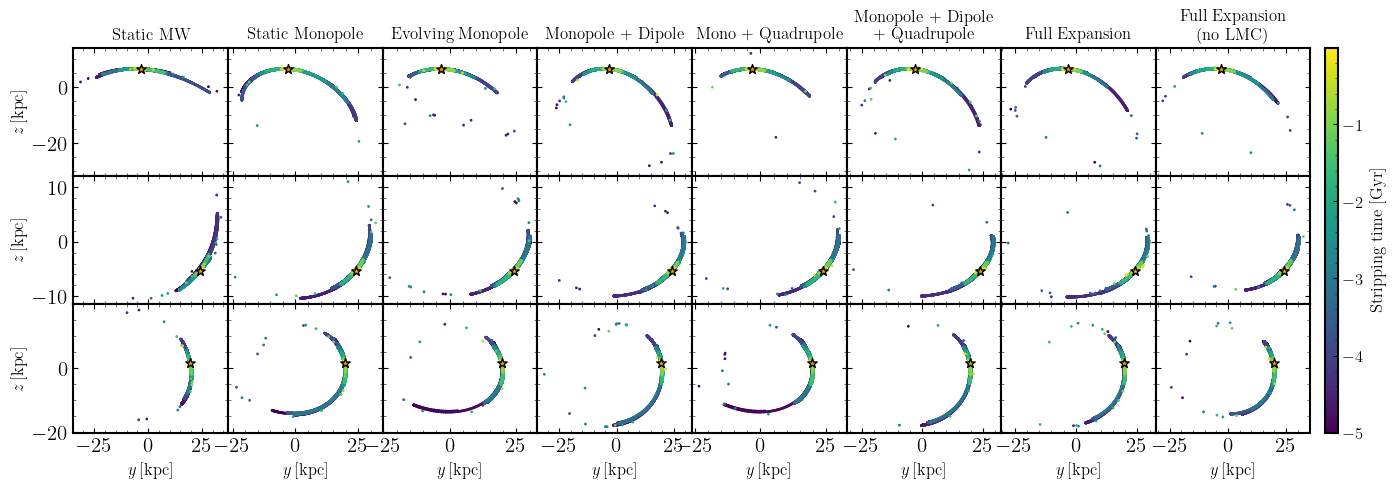

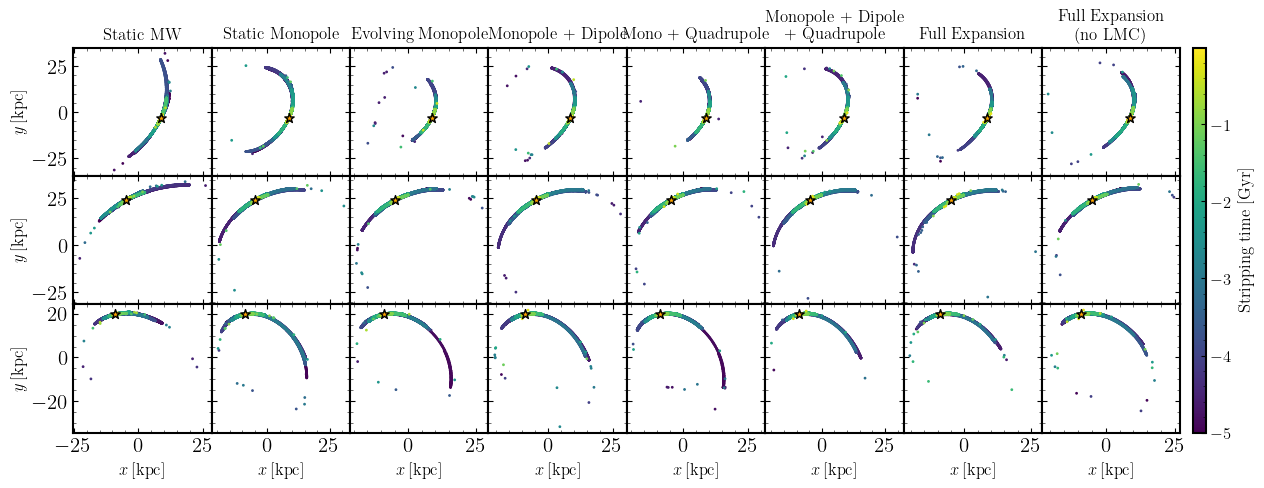

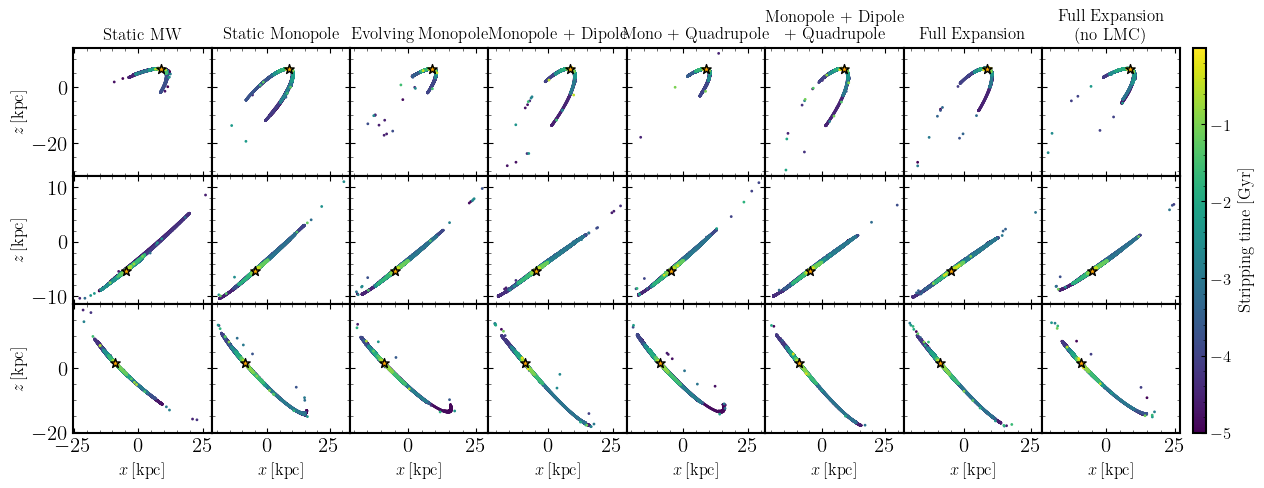

In [7]:
streams = list(['stream_0', 'stream_1', 'stream_2']) 
path = '/mnt/ceph/users/rbrooks/oceanus/analysis/stream-runs/combined-files/'
plotname = 'stream_cartesian'

plot_stream_cartesian(streams, path, plotname, False)

### Plotting summary statistics

In [8]:
def rv_dispersion(p, v):
    
    galcen_v_sun = (11.1, 245, 7.3)*u.km/u.s
    galcen_distance = 8.249*u.kpc
    
    positions = p + Model.expansion_centres(0.)[:3]
    velocities = v + Model.expansion_centre_velocities(0.)[:3]
    
    posvel_gc = SkyCoord(x=positions[:,0]*u.kpc, y=positions[:,1]*u.kpc, z=positions[:,2]*u.kpc,
                         v_x=velocities[:,0]*u.km/u.s, v_y=velocities[:,1]*u.km/u.s, v_z=velocities[:,2]*u.km/u.s ,
                         frame='galactocentric', galcen_distance=galcen_distance, galcen_v_sun=galcen_v_sun)
    posvel_galactic = posvel_gc.transform_to('galactic')
    posvel_galactic_rc = gc.reflex_correct(posvel_galactic)
    rvs =  posvel_galactic_rc.radial_velocity
    
    return np.nanstd(rvs)

In [9]:
def lons_lats(pos, vel):
    prog = gd.PhaseSpacePosition(pos[0] * u.kpc, vel[0] * u.km / u.s)
    stream = gd.PhaseSpacePosition(pos[1:].T * u.kpc, vel[1:].T * u.km / u.s)
    R1 = Rotation.from_euler("z", -prog.spherical.lon.degree, degrees=True)
    R2 = Rotation.from_euler("y", prog.spherical.lat.degree, degrees=True)
    R_prog0 = R2.as_matrix() @ R1.as_matrix()  

    new_vxyz = R_prog0 @ prog.v_xyz
    v_angle = np.arctan2(new_vxyz[2], new_vxyz[1])
    R3 = Rotation.from_euler("x", -v_angle.to_value(u.degree), degrees=True)
    R = (R3 * R2 * R1).as_matrix()

    stream_rot = gd.PhaseSpacePosition(stream.data.transform(R))
    stream_sph = stream_rot.spherical
    lon = stream_sph.lon.wrap_at(180*u.deg).degree
    lat = stream_sph.lat.degree
    return lon, lat

In [10]:
def local_veldis(lons, vfs):

    # Compute percentiles
    lower_value = np.nanpercentile(lons, 0.1)
    upper_value = np.nanpercentile(lons, 99.9)
    # Filter lons_mainbody
    lons_mainbody = lons[(lons >= lower_value) & (lons <= upper_value)]
    vfs_mainbody = vfs[1:][(lons >= lower_value) & (lons <= upper_value)] #excludes progenitor [1:]
    # Create bins
    lon_bins = np.linspace(np.nanmin(lons_mainbody), np.nanmax(lons_mainbody), 50)
    # Compute absolute velocity norms
    vfs_absol = np.linalg.norm(vfs_mainbody, axis=1)
    # Slice lons_mainbody into bins
    bin_indices = np.digitize(lons_mainbody, lon_bins)
    # Create a mask array
    mask = np.zeros((len(lons_mainbody), len(lon_bins) - 1), dtype=bool)
    for i in range(1, len(lon_bins)):
        mask[:, i - 1] = (bin_indices == i)

    # Calculate standard deviation for each bin
    local_veldis = np.array([np.std(vfs_absol[m]) for m in mask.T])
    return np.nanmedian(local_veldis)

In [11]:
rgal = []
peris = []
apos = []
widths = []
lengths = []
av_lon = []
av_lat = []
veldis_global = []
loc_veldis = []
lmc_sep = []
pole_b = []
pole_b_dis = []
pole_l = []
pole_l_dis = []
masses = []
energy = []
Ls = []
Lzs = []

path = '/mnt/ceph/users/rbrooks/oceanus/analysis/stream-runs/combined-files/'
potential = 'Full-MWhalo-MWdisc-LMC.hdf5'

Nstreams = 1024
for i in range(Nstreams):
    data_path = pathlib.Path(path) / potential 
    with h5py.File(data_path,'r') as file:
        
        if i ==1:
            pot = file['stream_{}'.format(i)]['potential'][()].decode('utf-8')
        
        pos = np.array(file['stream_{}'.format(i)]['positions'])[-1]
        vel = np.array(file['stream_{}'.format(i)]['velocities'])[-1]
        lons, lats = lons_lats(pos, vel)
        loc_veldis.append(local_veldis(lons, vel))
        # veldis_global.append(np.nanstd(np.linalg.norm(vel,axis=1)))

        rgal.append( np.nanmedian(np.linalg.norm(np.array(file['stream_{}'.format(i)]['positions'])[-1],axis=1)) )
        peris.append(np.array(file['stream_{}'.format(i)]['pericenter']))
        apos.append(np.array(file['stream_{}'.format(i)]['apocenter']))
        widths.append(np.array(file['stream_{}'.format(i)]['width']))
        lengths.append(np.array(file['stream_{}'.format(i)]['length']))
        av_lon.append(np.array(file['stream_{}'.format(i)]['av_lon']))
        av_lat.append(np.array(file['stream_{}'.format(i)]['av_lat']))
        lmc_sep.append(np.array(file['stream_{}'.format(i)]['lmc_sep']))
        pole_b.append(np.nanmedian(np.array(file['stream_{}'.format(i)]['pole_b'])[-1]))
        pole_l.append(np.nanmedian(np.array(file['stream_{}'.format(i)]['pole_l'])[-1]))
        pole_b_dis.append(np.nanstd(np.array(file['stream_{}'.format(i)]['pole_b'])[-1]))
        pole_l_dis.append(np.nanstd(np.array(file['stream_{}'.format(i)]['pole_l'])[-1]))
        masses.append(np.array(file['stream_{}'.format(i)]['progenitor-mass']))
        energy.append(np.nanmedian(np.array(file['stream_{}'.format(i)]['energies'])[-1]))
        Ls.append(np.nanmedian(np.array(file['stream_{}'.format(i)]['L'])[-1]))
        Lzs.append(np.nanmedian(np.array(file['stream_{}'.format(i)]['Lz'])[-1]))

/mnt/sw/nix/store/gpkc8q6zjnp3n3h3w9hbmbj6gjbxs85w-python-3.10.10-view/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/mnt/sw/nix/store/gpkc8q6zjnp3n3h3w9hbmbj6gjbxs85w-python-3.10.10-view/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/mnt/sw/nix/store/gpkc8q6zjnp3n3h3w9hbmbj6gjbxs85w-python-3.10.10-view/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Histogram of poles

In [12]:
path = '/mnt/ceph/users/rbrooks/oceanus/analysis/stream-runs/combined-files/'
def pole_hist(path, plotname, savefig=False):
    
    potentials = list(['static-mwh-only.hdf5','rm-MWhalo-full-MWdisc-full-LMC.hdf5', 'em-MWhalo-full-MWdisc-full-LMC.hdf5', 'md-MWhalo-full-MWdisc-full-LMC.hdf5', \
                       'mq-MWhalo-full-MWdisc-full-LMC.hdf5', 'mdq-MWhalo-full-MWdisc-full-LMC.hdf5', 'Full-MWhalo-MWdisc-LMC.hdf5', \
                       'full-MWhalo-full-MWdisc-no-LMC.hdf5'])
    labels = list(['Static MW','Static Monopole', 'Evolving Monopole', 'Monopole + Dipole', 'Mono + Quadrupole', \
                      'Monopole + Dipole \n + Quadrupole', 'Full Expansion', 'Full Expansion \n (no LMC)'])
    fig, ax = plt.subplots(1,1, figsize=(5,2.5))

    Nstreams = 128
    for j in range(len(potentials)):    
        data_path = pathlib.Path(path) / potentials[j]
        pole_b = []
        for i in range(Nstreams):
            with h5py.File(data_path,'r') as file:

                pole_b.append(np.nanmedian(np.array(file['stream_{}'.format(i)]['pole_b'])[-1]))
                
        sinb = np.sin((pole_b*u.deg).to(u.rad)).value        
        plt.sca(ax)
        plt.hist(sinb, bins=np.linspace(-1,1,20), histtype='step', fill=False, label=labels[j])

    plt.xlabel('$\sin(b_{\mathrm{pole}})$')
    plt.ylabel('N')
    plt.legend(bbox_to_anchor=(1.45,1.), fontsize=9)
    
    if savefig==True:
        plt.savefig('/mnt/ceph/users/rbrooks/oceanus/analysis/figures/{}'.format(plotname))

KeyboardInterrupt: 

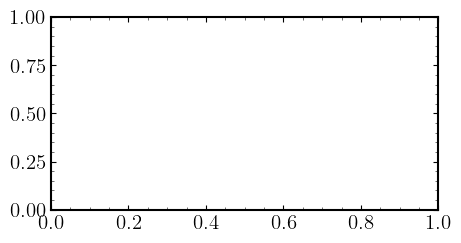

In [102]:
pole_hist(path, 'sinbpole-histogram', False)

Orbital radial phase vs velocity dispersion & Pericenter vs velocity dispersion

In [101]:
# def radialphase_peris_veldis(galdist, pericenters, apocenters, sigmavs, mass,plotname, potential, savefig=False):

#     f = (np.array(galdist) - np.array(pericenters)) / (np.array(apocenters) - np.array(pericenters))
#     fig, ax = plt.subplots(1,2, figsize=(9,2.75), sharey='row')


#     plt.subplots_adjust(wspace=0.)
#     plt.sca(ax[0])
#     plot=plt.scatter(f, sigmavs, c=mass, cmap='plasma_r', edgecolor='k',
#                    norm=matplotlib.colors.LogNorm(vmin=1e4, vmax=1e6))

#     plt.xlabel(r'$\frac{r_{\mathrm{gal}} - r_p}{r_a - r_p}$')
#     plt.ylabel('$\sigma_{v,\,\mathrm{loc}}$ [km/s]')
#     plt.xlim(-0.2,1.2)

#     plt.sca(ax[1])
#     plot=plt.scatter(pericenters, sigmavs, c=mass, cmap='plasma_r', edgecolor='k',
#                    norm=matplotlib.colors.LogNorm(vmin=1e4, vmax=1e6))
#     plt.xlabel('$r_{p}$ [kpc]')
#     plt.xlim(6,30)
#     plt.ylim(0,30)
    
#     cb = fig.colorbar(plot, ax=[ax[0], ax[1]],location='right', aspect=30, pad=0.01)
#     cb.set_label(r'$M_{\mathrm{prog}}\,[\mathrm{M}_{\odot}$]')
#     cb.ax.tick_params(labelsize=12)
    
#     if savefig==True:
#         plt.savefig('/mnt/ceph/users/rbrooks/oceanus/analysis/figures/{}'.format(plotname + '_' + potential))

In [13]:
def radialphase_peris_veldis(galdist, pericenters, apocenters, sigmavs, mass,plotname, potential, savefig=False):

    f = (np.array(galdist) - np.array(pericenters)) / (np.array(apocenters) - np.array(pericenters))
    fig, ax = plt.subplots(1,2, figsize=(9,2.75), sharey='row')

    plt.subplots_adjust(wspace=0.)
    plt.sca(ax[0])
    
    x_range, xbins = (0, 1) , 20
    y_range, ybins = (0, 40) , 15
    plot = plt.hexbin(f, sigmavs, cmap='magma',
                      gridsize=(xbins, ybins), extent=(x_range[0], x_range[1], y_range[0], y_range[1]),
                      norm=matplotlib.colors.LogNorm(vmin=1e0, vmax=1e2))
    
    plt.xlabel(r'$\frac{r_{\mathrm{gal}} - r_p}{r_a - r_p}$')
    plt.ylabel('$\sigma_{v,\,\mathrm{loc}}$ [km/s]')
    plt.xlim(-0.05,1.05)

    plt.sca(ax[1])
    x_range, xbins = (9, 26) , 20
    y_range, ybins = (0, 40) , 15
    plot = plt.hexbin(pericenters, sigmavs, cmap='magma',
                      gridsize=(xbins, ybins), extent=(x_range[0], x_range[1], y_range[0], y_range[1]),
                      norm=matplotlib.colors.LogNorm(vmin=1e0, vmax=1e2)) 
    plt.xlabel('$r_{p}$ [kpc]')
    plt.xlim(9,26)
    plt.ylim(0,30)
    
    cb = fig.colorbar(plot, ax=[ax[0], ax[1]],location='right', aspect=30, pad=0.01)
    cb.set_label('Number counts')
    cb.ax.tick_params(labelsize=12)
    
    if savefig==True:
        plt.savefig('/mnt/ceph/users/rbrooks/oceanus/analysis/figures/{}'.format(plotname + '_' + potential))

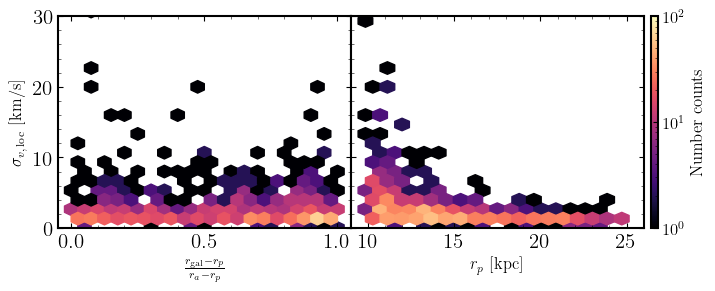

In [14]:
radialphase_peris_veldis(rgal, peris, apos, loc_veldis, masses, 'radialphase_peris_veldis', pot, False)

Pole dispersion vs pericenters and distance

In [15]:
def poledisp_peri(poledis_l, poledis_b, pericenters, mass, plotname, potential, savefig=False):

    fig, ax = plt.subplots(1,2, figsize=(9,2.75), sharey='row')

    plt.subplots_adjust(wspace=0.)
    plt.sca(ax[0])
    x_bins_log = np.logspace(np.log10(0.1), np.log10(250), 25)
    y_range, ybins = (9, 26) , 20
    plot = plt.hexbin(np.log10(poledis_l), pericenters, cmap='magma',
                      gridsize=(x_bins_log.size, ybins),
                      norm=matplotlib.colors.LogNorm(vmin=1e0, vmax=1e2))

    plt.xlabel(r'$\log_{10}(\sigma_{l,\mathrm{pole}})\,[^\circ]$')
    plt.xlim(np.log10(0.1),np.log10(300))
    plt.ylim(9,26)
    plt.ylabel('$r_p$ [kpc]')

    plt.sca(ax[1])
    x_bins_log = np.logspace(np.log10(0.1), np.log10(50), 20)
    y_range, ybins = (9, 26) , 20
    plot = plt.hexbin(np.log10(poledis_b), pericenters, cmap='magma',
                      gridsize=(x_bins_log.size, ybins),
                      norm=matplotlib.colors.LogNorm(vmin=1e0, vmax=1e2))
    plt.xlim(np.log10(0.1),np.log10(50))
    plt.xlabel(r'$\log_{10}(\sigma_{b,\mathrm{pole}})\,[^\circ]$')

    cb = fig.colorbar(plot, ax=[ax[0], ax[1]],location='right', aspect=30, pad=0.01)
    cb.set_label('Number counts')
    cb.ax.tick_params(labelsize=12)
    
    if savefig==True:
        plt.savefig('/mnt/ceph/users/rbrooks/oceanus/analysis/figures/{}'.format(plotname + '_' + potential))

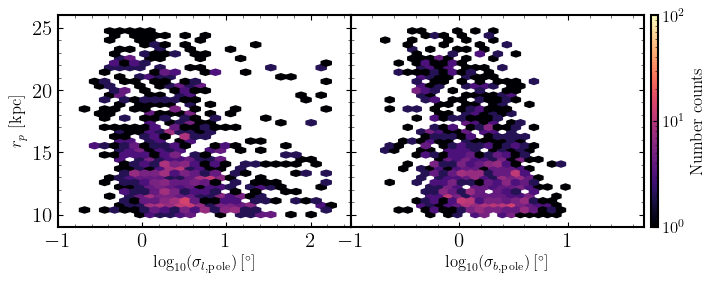

In [16]:
poledisp_peri(pole_l_dis, pole_b_dis, peris, masses, 'poledisp_peri', pot, False)

In [17]:
def poledisp_distance(poledis_l, poledis_b, distances, mass, plotname, potential, savefig=False):
    
    fig, ax = plt.subplots(1,2, figsize=(9,2.75), sharey='row')

    plt.subplots_adjust(wspace=0.)
    plt.sca(ax[0])
    x_bins_log = np.logspace(np.log10(0.1), np.log10(250), 25)
    y_range, ybins = (0, 55) , 20
    plot = plt.hexbin(np.log10(poledis_l), distances, cmap='magma',
                      gridsize=(x_bins_log.size, ybins),
                      norm=matplotlib.colors.LogNorm(vmin=1e0, vmax=1e2))

    plt.xlabel(r'$\log_{10}(\sigma_{l,\mathrm{pole}})\,[^\circ]$')
    # plt.xscale('log')
    plt.ylabel('$r_{\mathrm{gal}}$ [kpc]')
    plt.xlim(np.log10(0.1),np.log10(300))
    plt.ylim(0,55)

    plt.sca(ax[1])
    x_bins_log = np.logspace(np.log10(0.1), np.log10(50), 20)
    y_range, ybins = (9, 26) , 20
    plot = plt.hexbin(np.log10(poledis_b), distances, cmap='magma',
                      gridsize=(x_bins_log.size, ybins),
                      norm=matplotlib.colors.LogNorm(vmin=1e0, vmax=1e2))
    plt.xlabel(r'$\log_{10}(\sigma_{b,\mathrm{pole}})\,[^\circ]$')
    # plt.xscale('log')
    plt.xlim(np.log10(0.1),np.log10(50))

    cb = fig.colorbar(plot, ax=[ax[0], ax[1]],location='right', aspect=30, pad=0.01)
    cb.set_label('Number counts')
    cb.ax.tick_params(labelsize=12)
    
    if savefig==True:
        plt.savefig('/mnt/ceph/users/rbrooks/oceanus/analysis/figures/{}'.format(plotname + '_' + potential))

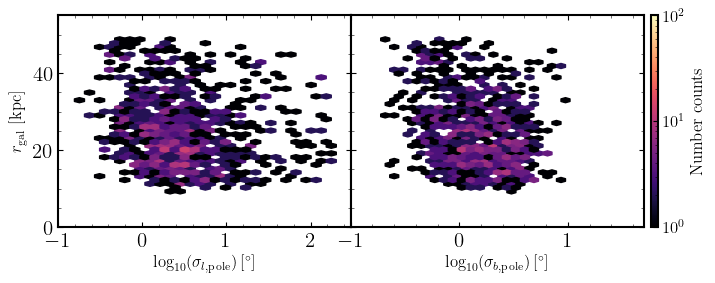

In [18]:
poledisp_distance(pole_l_dis, pole_b_dis, rgal, masses, 'poledisp_distance', pot, False)

Mollewide plot of median stream poles coloured by distance

In [19]:
def mollewide_poles_distance(polel, poleb, distance, plotname, potential, savefig=False):
    
    plt.figure(figsize=(8,5))
    plt.subplot(projection="mollweide")
    plt.grid(alpha=.25)
    sc=plt.scatter((polel*u.deg).to(u.rad), (poleb*u.deg).to(u.rad),
               c=distance, cmap='plasma_r', edgecolor='k', rasterized=True)

    cb=plt.colorbar(sc,location='right', aspect=30, pad=0.02, shrink=.65)
    cb.set_label(r'Distance [kpc]')
    cb.ax.tick_params(labelsize=12)
    
    if savefig==True:
        plt.savefig('/mnt/ceph/users/rbrooks/oceanus/analysis/figures/{}'.format(plotname + '_' + potential))

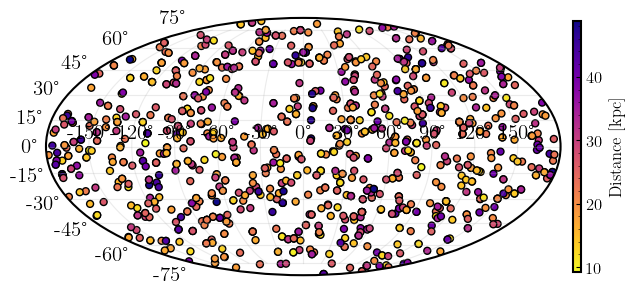

In [20]:
mollewide_poles_distance(pole_l, pole_b, rgal, 'mollewide_poles_distance', 'potential', False)

In [280]:
# fig, ax = plt.subplots(1,2, figsize=(9,2.75), sharey='row')

# plt.subplots_adjust(wspace=0.)
# plt.sca(ax[0])
# plot=plt.scatter((pole_l*u.deg).to(u.rad), rgal, c=masses, cmap='plasma_r', edgecolor='k',
#                norm=matplotlib.colors.LogNorm(vmin=1e4, vmax=1e6))

# plt.xlabel(r'$\bar{l}_{\mathrm{pole}}\,[^\circ]$')
# plt.ylabel('$r_{\mathrm{gal}}$ [kpc]')

# plt.sca(ax[1])
# plot=plt.scatter((pole_b*u.deg).to(u.rad), rgal, c=masses, cmap='plasma_r', edgecolor='k',
#                norm=matplotlib.colors.LogNorm(vmin=1e4, vmax=1e6))
# plt.xlabel(r'$\bar{b}_{\mathrm{pole}}\,[^\circ]$')

# cb = fig.colorbar(plot, ax=[ax[0], ax[1]],location='right', aspect=30, pad=0.01)
# cb.set_label(r'$M_{\mathrm{prog}}\,[\mathrm{M}_{\odot}$]')
# cb.ax.tick_params(labelsize=12)

width vs length

In [21]:
def width_length(width, length, mass, plotname, potential, savefig=False):
    
    fig, ax = plt.subplots(1,1, figsize=(5,3))
    x_bins_log = np.logspace(np.log10(1e-2), np.log10(3e1), 25)
    y_bins_log = np.logspace(np.log10(5e-1), np.log10(1e2), 25)
    plot = plt.hexbin(np.log10(width), np.log10(length), cmap='magma',
                      gridsize=(x_bins_log.size, y_bins_log.size),
                      norm=matplotlib.colors.LogNorm(vmin=1e0, vmax=1e2))
    plt.sca(ax)
    plt.xlabel('$\log_{10}(w)\,[^{\circ}]$')
    plt.ylabel('$\log_{10}(l)$ [kpc]')
    plt.xlim(np.log10(1e-2),np.log10(3e1))
    plt.ylim(np.log10(5e-1),np.log10(1e2))

    cb = fig.colorbar(plot, ax=ax,location='right', aspect=30, pad=0.01)
    cb.set_label('Number counts')
    cb.ax.tick_params(labelsize=12)
    
    if savefig==True:
        plt.savefig('/mnt/ceph/users/rbrooks/oceanus/analysis/figures/{}'.format(plotname + '_' + potential))

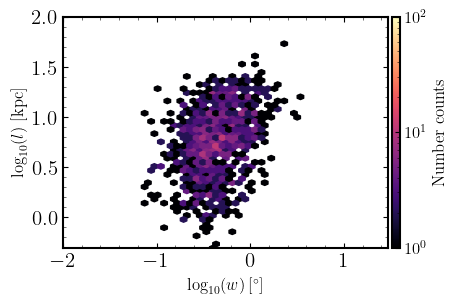

In [22]:
width_length(widths, lengths, masses, 'width_length', pot, False)

Median longitude vs latitude in stream frame

In [23]:
def av_lon_lat(lons, lats, mass, plotname, potential, savefig=False):
    
    fig, ax = plt.subplots(1,1, figsize=(5,3))
    
    x_range, xbins = (-5, 5) , 25
    y_range, ybins = (-5, 5) , 20
    plot = plt.hexbin(lons, lats, cmap='magma',
                      gridsize=(xbins, ybins), extent=(x_range[0], x_range[1], y_range[0], y_range[1]),
                      norm=matplotlib.colors.LogNorm(vmin=1e0, vmax=1e2))

    plt.sca(ax)
    plt.xlabel(r'$\bar{\psi_{1}}\,[^{\circ}]$')
    plt.ylabel(r'$\bar{\psi_{2}}\,[^{\circ}]$')
    plt.xlim(-5,5)
    plt.ylim(-5,5)

    cb = fig.colorbar(plot, ax=ax,location='right', aspect=30, pad=0.01)
    cb.set_label('Number counts')
    cb.ax.tick_params(labelsize=12)
    
    if savefig==True:
        plt.savefig('/mnt/ceph/users/rbrooks/oceanus/analysis/figures/{}'.format(plotname + '_' + potential))

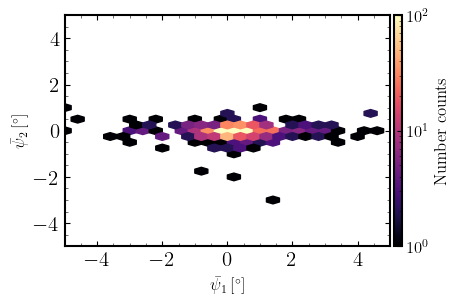

In [24]:
av_lon_lat(av_lon, av_lat, masses, 'av_lon_lat', pot, False)

Total mass (assuming all in stellar) vs velocity dispersion

In [25]:
def veldis_mstellar_rel(m):
    return (-5.28*np.log10(m)) + 53.55

def stellarmass_veldis(mass, veldis, plotname, potential, savefig=False):
    
    fig, ax = plt.subplots(1,1, figsize=(5,3)) 
    plt.scatter(np.array(masses)[veldis < veldis_mstellar_rel(mass)], np.array(veldis)[veldis < veldis_mstellar_rel(mass)], c='k', s=5, rasterized=True)
    plt.scatter(np.array(masses)[veldis > veldis_mstellar_rel(mass)], np.array(veldis)[veldis > veldis_mstellar_rel(mass)], c='r', s=5, rasterized=True)

    plt.sca(ax)
    plt.xlabel(r'$M_{\mathrm{*}}\,[\mathrm{M}_{\odot}]$')
    plt.ylabel(r'$\sigma_v$ [km/s]')
    plt.xscale('log')
    
    ms = np.logspace(4,6, 20, base=10.0)
    plt.plot(ms, veldis_mstellar_rel(ms), c='r', lw=1)
    plt.xlim(1e4,1e6)
    plt.ylim(0.1,110)
    
    Nstreams = len(np.array(masses)[veldis < veldis_mstellar_rel(mass)])
    fsurvived = np.round((Nstreams/len(masses)), 3)*100
    
    plt.annotate('phase-mixed', xy=(5.83e5,45), xytext=(4e5, 26), color='r', fontsize=8,
                arrowprops=dict(color='r', arrowstyle='->'))
    plt.annotate('stream', xy=(5.9e5,3), xytext=(4.75e5, 18), color='k', fontsize=8,
                arrowprops=dict(color='k', arrowstyle='->'))
    plt.annotate(r'$f_{\mathrm{survived}}$' + '= {}\%'.format(fsurvived), xy=(2.75e5, 90), 
                 xytext=(2.75e5, 100), color='k', fontsize=10,)
    
    if savefig==True:
        plt.savefig('/mnt/ceph/users/rbrooks/oceanus/analysis/figures/{}'.format(plotname + '_' + potential))

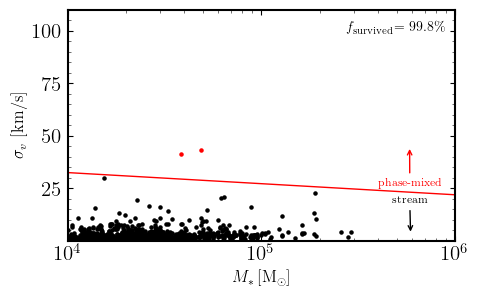

In [26]:
stellarmass_veldis(masses, loc_veldis, 'stellarmass_veldis', pot, False)

In [29]:
def rlmc_veldis(rlmc, veldis, peris, plotname, potential, savefig=False):
    
    fig, ax = plt.subplots(1,1, figsize=(5,3)) 
    
    x_range, xbins = (0, 50) , 25
    y_range, ybins = (0, 40) , 20
    plot = plt.hexbin(np.nanmin(rlmc,axis=1), veldis, cmap='magma',
                      gridsize=(xbins, ybins), extent=(x_range[0], x_range[1], y_range[0], y_range[1]),
                      norm=matplotlib.colors.LogNorm(vmin=1e0, vmax=1e2))

    plt.xlabel(r'Closest approach to LMC [kpc]')
    plt.ylabel(r'$\sigma_v$ [km/s]')
    plt.xlim(0,49)
    plt.ylim(0,31)
 
    cb = fig.colorbar(plot, ax=ax,location='right', aspect=30, pad=0.01)
    cb.set_label('Number counts')
    cb.ax.tick_params(labelsize=12)

    if savefig==True:
        plt.savefig('/mnt/ceph/users/rbrooks/oceanus/analysis/figures/{}/{}'.format(potential, plotname + '_' + potential))

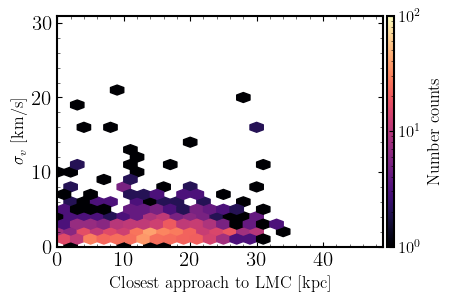

In [30]:
rlmc_veldis(lmc_sep, loc_veldis, peris, 'rlmc_veldis_cut10kpc', pot, False)